# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we will use autodiff to compute all gradient/Hessian terms (e.g. Q, W, R) and see if that gives good p-values. 

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

In [30]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 2, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = [1.0; rand(-0.02:0.04:0.02, p-1)]
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Normal,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 5, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [33]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 200,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36


In [34]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [1.0, -0.02, 0.02]
qc_model.β = [0.9989335436435152, -0.015114878748840883, 0.0186815395201153]
qc_model.∇β = [-0.0013584483275899117, -0.00221718677539684, -0.002136200690102008]
θtrue = [0.1, 0.1]
qc_model.θ = [0.07913525218854363, 0.06964642221445527]
qc_model.∇θ = [0.0009986232210312807, -0.00019457508084430586]


# Loglikelihood function friendly to autodiff

In [5]:
autodiff_loglikelihood(β) = QuasiCopula.loglikelihood(β, qc_model, z)

# autodiff Gradient
∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)

# autodiff Hessian
∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)

#7 (generic function with 1 method)

First, check if `autodiff_loglikelihood` returns same answer as `QuasiCopula.loglikelihood!`

In [6]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
fullβ = [qc_model.β; qc_model.θ; 0.0] # poisson or bernoulli
# fullβ = [qc_model.β; qc_model.θ; qc_model.τ; 0.0] # normal

@show autodiff_loglikelihood(fullβ)
@show QuasiCopula.loglikelihood!(qc_model, false, false);

autodiff_loglikelihood(fullβ) = -15184.429634944136
QuasiCopula.loglikelihood!(qc_model, false, false) = -15184.429634945503


Lets compute a few Hessians

In [7]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 1

6×6 Matrix{Float64}:
 -2828.24       -95.9599     96.4885     1841.42       1563.08     -7.99025
   -95.9599   -3507.03      -11.0075      -51.1999      -79.531    10.6713
    96.4885     -11.0075  -3445.95         69.2266       67.557    -8.33106
  1841.42       -51.1999     69.2266   -11486.9        1733.53     -0.311129
  1563.08       -79.531      67.557      1733.53      -1737.84    -21.646
    -7.99025     10.6713     -8.33106      -0.311129    -21.646  -301.733

In [8]:
# check correlation between VC params and beta
i, j = 1, 4
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j])
i, j = 1, 5
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j]);

(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.32306666769760506
(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.7050445705426172


In [9]:
i = 10
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 10

6×6 Matrix{Float64}:
 -2828.24       -95.9599     96.4885    1841.42     1563.08        0.36294
   -95.9599   -3507.03      -11.0075     -51.1999    -79.531      -2.8895
    96.4885     -11.0075  -3445.95        69.2266     67.557      37.1005
  1841.42       -51.1999     69.2266  -11486.9      1733.53      134.446
  1563.08       -79.531      67.557     1733.53    -1737.84        6.45871
     0.36294     -2.8895     37.1005     134.446       6.45871  -949.597

In [10]:
# check correlation between VC params and beta
i, j = 1, 4
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j])
i, j = 1, 5
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j]);

(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.32306666769760506
(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.7050445705426172


In [11]:
W = -Hfull[1:end-1, end]
Q = -Hfull[end, end]
Pinv = inv(-Hfull[1:end-1, 1:end-1])
R = ∇logl(fullβ)[end]
S = R * inv(Q - W'*Pinv*W) * R
pval = ccdf(Chisq(1), S)

0.24820715125159407

In [12]:
∇logl(fullβ)

6-element Vector{Float64}:
   2.5799908098811386e-7
   1.079411837690003e-10
   2.6935144226136742e-8
  -5.492520411820578e-7
  -7.299600879306922e-8
 -35.237650740823355

## Check QQ plots

### Bernoulli

In [17]:
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 35.536640 seconds (29.06 M allocations: 3.480 GiB, 1.20% gc time, 6.68% compilation time)


1000-element Vector{Float64}:
 0.9082103467933702
 0.33322730986602533
 0.8631682636317813
 0.8942818995767361
 0.2573701468844197
 0.9432763125866032
 0.0109444927059893
 0.6824260121036194
 0.2887035734836703
 0.24820715125159407
 0.2595268479816389
 0.764386443126145
 0.3230545745560405
 ⋮
 0.49303760017205567
 0.5306199107527328
 0.2774797301701202
 0.5163978492199007
 0.33683146631805405
 0.9644165626735308
 0.1332047183108521
 0.5646456334716937
 0.7028231353838417
 0.23289181311783294
 0.2808610124805867
 0.3215991810019335

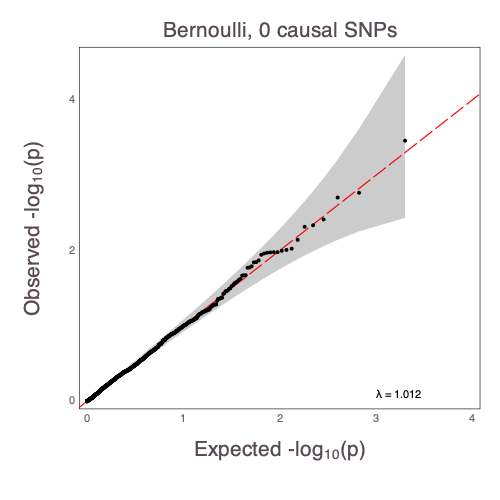

In [18]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

### Poisson

In [25]:
@time pvals = GWASCopulaVCModel_autodiff(qc_model, G)

 37.283363 seconds (20.06 M allocations: 3.012 GiB, 0.95% gc time)


1000-element Vector{Float64}:
 0.7335607362655298
 0.05561986617544375
 0.9318413103446126
 0.774316724137551
 0.6581830920104301
 0.16630436538524235
 0.27496773200086766
 0.7799540761616317
 0.07489814132532885
 0.32893408662735246
 0.13374939184758827
 0.4340006175080037
 0.7011826940533106
 ⋮
 0.7674875623368472
 0.6632927625672214
 0.9822199975118755
 0.5261283212757659
 0.44051367043288037
 0.23187984899221253
 0.9101490694501337
 0.7282891684686048
 0.016576832085031825
 0.04457421310867708
 0.5376842519625814
 0.5223071431449539

In [26]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [27]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [28]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 0.0003482285776662325
 0.0011819008525488484
 0.004777592969758005
 0.005220046169538997
 0.006560549272302478
 0.007049984247155555
 0.007852565271368557
 0.00943076574527002
 0.010066462712521826
 0.010365805360960066
 0.012549102350645248
 0.014012732613295035
 0.014297763459150289
 ⋮
 0.9916274916624682
 0.992926960968034
 0.9930986396560096
 0.9937510479256157
 0.9941562025137491
 0.9944490581394926
 0.995550422199266
 0.9967937057735273
 0.9969054706511723
 0.9981347339507739
 0.9981544109359498
 0.9988153987731558

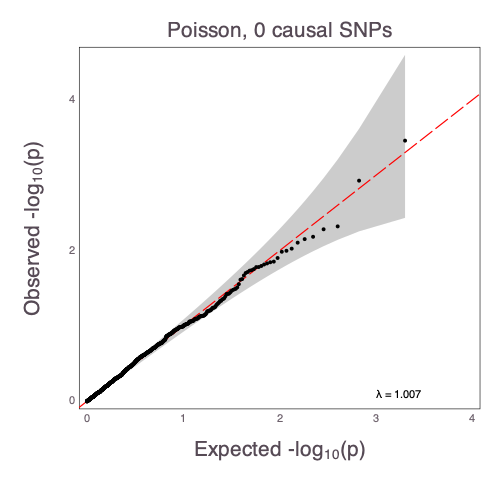

In [29]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

### Normal

In [43]:
@time pvals = GWASCopulaVCModel_autodiff(qc_model, G)

 36.127481 seconds (33.34 M allocations: 9.144 GiB, 2.90% gc time, 2.76% compilation time)


1000-element Vector{Float64}:
 0.8574073868061233
 0.28065988044433215
 0.675654641145359
 0.8433865164299649
 0.6357581397194695
 0.8444905468038253
 0.01027099479181637
 0.8787191929204816
 0.4260896928282632
 0.36529215605025606
 0.5482577341965349
 0.3869472250406819
 0.894085859499028
 ⋮
 0.2813110788035354
 0.7296208614246543
 0.2773545933010809
 0.18706122166716654
 0.29653571548583935
 0.7231442100411721
 0.501074493158175
 0.9172329423547374
 0.6519523581836668
 0.13988016310858375
 0.13266431696050854
 0.2004640259813218

In [39]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [40]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [41]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 0.0003482285776662325
 0.0011819008525488484
 0.004777592969758005
 0.005220046169538997
 0.006560549272302478
 0.007049984247155555
 0.007852565271368557
 0.00943076574527002
 0.010066462712521826
 0.010365805360960066
 0.012549102350645248
 0.014012732613295035
 0.014297763459150289
 ⋮
 0.9916274916624682
 0.992926960968034
 0.9930986396560096
 0.9937510479256157
 0.9941562025137491
 0.9944490581394926
 0.995550422199266
 0.9967937057735273
 0.9969054706511723
 0.9981347339507739
 0.9981544109359498
 0.9988153987731558

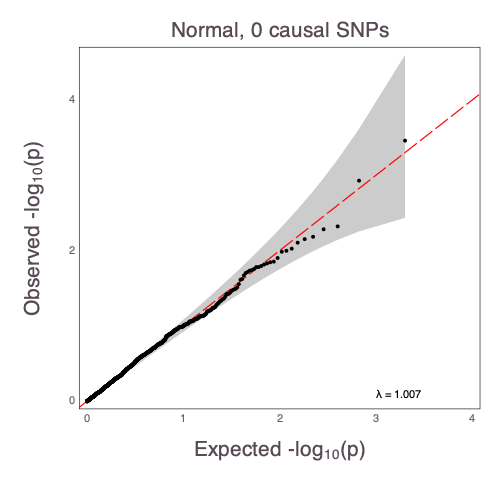

In [42]:
qq(pvals, dpi=100, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))

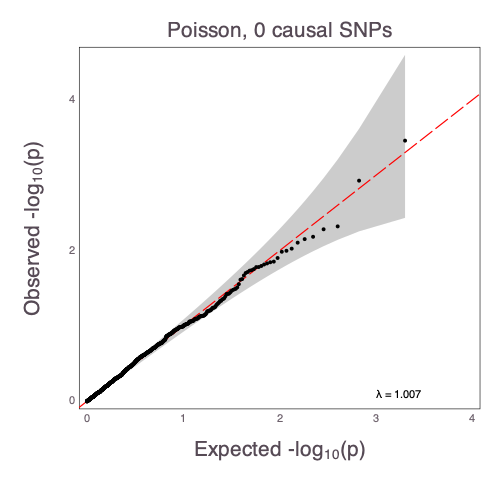

In [22]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

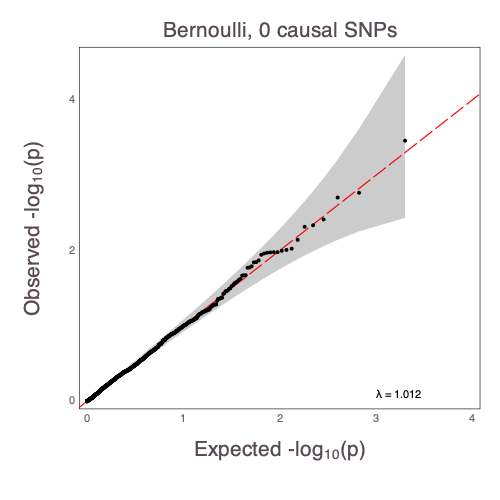

In [38]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

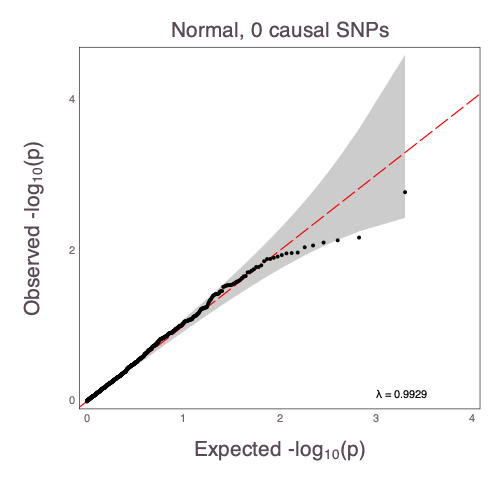

In [79]:
qq(pvals, dpi=100, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))